# Experiments for Draft Analsys in MOBA Games

First we try K-Means Clustering with different numbers of clusters, on Dota2 and LoL Drafts augmented by semantic positions.  
Second we try Logistic Regression to predict the winner of a match, we test different feature sets (with train/test split):  
    - just the hero selection  
    - hero selection and synergy+counter  
    - hero selection and cluster winrate (and synergy+counter)  
Third we additionaly try clustering for Dota2 by encoding the Drafts by hero roles.  
Fourth we could try if a neural network improves over log regression.  

## Step 0 - import datasets and predict position for Dota2

In [6]:
import json
from datetime import date
from datetime import datetime

with open('joined_all_matches.json', 'r') as file:
    raw_games = json.load(file)

dota2_highelo_games = [game for game in raw_games if game.get('game_mode') in ('game_mode_all_draft','game_mode_captains_mode') and game.get('high_elo') == True]
dota2_lowelo_games = [game for game in raw_games if game.get('game_mode') in ('game_mode_all_draft','game_mode_captains_mode') and game.get('high_elo') == False]
print(f"Dota2 highelo dataset: {len(dota2_highelo_games)}, lowelo dataset: {len(dota2_lowelo_games)}")

with open('all_lol_matches_highelo.json', 'r') as file:
    lol_highelo_games = json.load(file)
    lol_highelo_games = [game for game in lol_highelo_games if date.fromtimestamp(game['start_date']/1000) > date(2025, 2, 5)]
with open('all_low_lol_matches.json', 'r') as file:
    lol_lowelo_games = json.load(file)
    lol_lowelo_games = [game for game in lol_lowelo_games if date.fromtimestamp(game['start_date']/1000) > date(2025, 2, 5)]
print(f"LoL highelo dataset: {len(lol_highelo_games)}, lowelo dataset: {len(lol_lowelo_games)}")

Dota2 highelo dataset: 23412, lowelo dataset: 7100
LoL highelo dataset: 30060, lowelo dataset: 20381


In [5]:
print(lol_highelo_games[0])
print(dota2_highelo_games[0])

{'match_id': 'EUW1_7307744604', 'start_date': 1739656148685, 'duration': 941, 'blueside_win': False, 'team_comp': {'blueside': {'24': 'TOP', '72': 'JUNGLE', '81': 'BOTTOM', '910': 'MIDDLE', '111': 'UTILITY'}, 'redside': {'114': 'TOP', '131': 'JUNGLE', '133': 'MIDDLE', '42': 'BOTTOM', '518': 'UTILITY'}}, 'bans': {'blueside': [{'championId': 432, 'pickTurn': 1}, {'championId': 800, 'pickTurn': 2}, {'championId': 143, 'pickTurn': 3}, {'championId': -1, 'pickTurn': 4}, {'championId': 86, 'pickTurn': 5}], 'redside': [{'championId': 112, 'pickTurn': 6}, {'championId': 34, 'pickTurn': 7}, {'championId': 893, 'pickTurn': 8}, {'championId': 555, 'pickTurn': 9}, {'championId': 143, 'pickTurn': 10}]}}
{'match_id': 8108259917, 'patch': 56, 'radiant_win': True, 'duration': 1757, 'high_elo': True, 'lobby_type': 'lobby_type_normal', 'game_mode': 'game_mode_all_draft', 'leavers': 0, 'draft': [['dire_pick', 80], ['dire_pick', 10], ['radiant_pick', 135], ['radiant_pick', 58], ['dire_pick', 21], ['radian

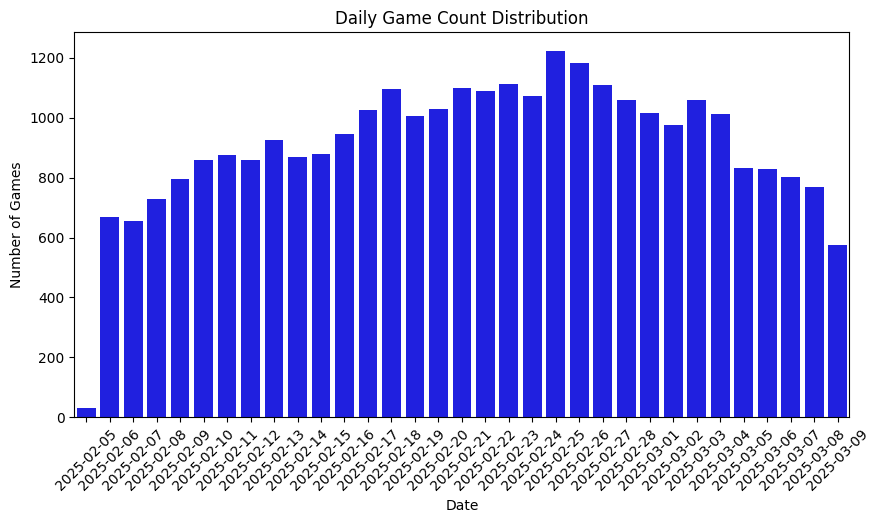

In [319]:
# Convert timestamps to datetime and extract the date
df = pd.DataFrame(lol_highelo_games)
#print(df)
df["date"] = pd.to_datetime(df["start_date"], unit="ms").dt.date  # Convert to date (YYYY-MM-DD)

# Count occurrences per day
game_counts = df["date"].value_counts().reset_index()
game_counts.columns = ["date", "count"]
game_counts = game_counts.sort_values("date")  # Ensure chronological order

# Plot the distribution using Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(data=game_counts, x="date", y="count", color="b")
plt.xticks(rotation=45)  # Rotate for better readability
plt.xlabel("Date")
plt.ylabel("Number of Games")
plt.title("Daily Game Count Distribution")
plt.show()

In [2]:
with open('champion.json', 'r', encoding='utf-8') as file:
    lol_hero_data = json.load(file)

lol_heroes = {champ['key']:champ['name'] for champ in lol_hero_data['data'].values()}
lol_hero_ids = [hero_id for hero_id in lol_heroes.keys()]

with open('opendota_heroes.json', 'r') as file:
    dota2_hero_data = json.load(file)

dota2_heroes = {hero_id:data["localized_name"] for hero_id,data in dota2_hero_data.items()}
dota2_hero_ids = [hero_id for hero_id in dota2_heroes.keys()]
print(len(lol_heroes),'\n', len(dota2_heroes))

170 
 126


In [4]:
#predict Position1-5 for Dota2 games

def predict_positions(team_dict, is_radiant:bool):
    total_gold_per_min = sum([stats['gold_per_min'] for stats in team_dict.values()])
    total_xp_per_min = sum([stats['xp_per_min'] for stats in team_dict.values()])
    total_rescource_per_min_team = total_gold_per_min + total_xp_per_min
    team = []
    for hero_id, stats in team_dict.items():
        total_rescources_player = stats['gold_per_min'] + stats['xp_per_min']
        relative_rescources = total_rescources_player / total_rescource_per_min_team
        lane = stats['lane']
        team.append((hero_id, lane, relative_rescources))
    
    sorted_by_rescources = sorted(team, key=lambda x: x[2],reverse=True)
    positions = {hero_id:0 for hero_id in team_dict.keys()}
    
    #first 3 players should include each lane (safe, mid, off)
    if not sorted(list(p[1] for p in sorted_by_rescources[:3])) == [1,2,3]:
        return False
   
    #last 2 players should include hardsupport on the safelane
    if not (sorted_by_rescources[3][1] == 1 or sorted_by_rescources[4][1] == 1):
        return False
    
    for hero_id, lane, _ in sorted_by_rescources[:3]:
        positions[hero_id] = lane #carries 1-3
    for hero_id, lane, _ in sorted_by_rescources[3:]:
        positions[hero_id] = 5 if lane == 1 else 4 #hardsupport (pos 5) in safelane (lane 1), remaining pos 4
    return positions

def predict_positions_for_games(games):
    converted_games = []
    orig_n = len(games)
    games = [game for game in games if 'lane' in next(iter(game['team_comp']['dire'].values()))] #remove games with missing lane info
    for game in games:
        radiant_team = game['team_comp']['radiant']
        dire_team = game['team_comp']['dire']
        radiant_win = game['radiant_win']
        if radiant_positions := predict_positions(radiant_team, is_radiant=True):
            if dire_postions := predict_positions(dire_team, is_radiant=False):
                converted_games.append({'radiant':radiant_positions,'dire':dire_postions,'radiant_win':game['radiant_win']})
                continue
    n_pred_games = len(converted_games)
    print(f"Could predict hero positions for {n_pred_games} out of {orig_n} games ({int((n_pred_games/orig_n)*100)}%)")
    return converted_games

In [7]:
def convert_lol_positions(team):
    positions = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
    try:
        return {hero_id:positions.index(role) + 1 for hero_id, role in team.items()}
    except ValueError:
        return None

n_high, n_low = len(lol_highelo_games), len(lol_lowelo_games)

lol_highelo_games = [{'team1_win':game['blueside_win'], 
                      'team1':convert_lol_positions(game['team_comp']['blueside']), 
                      'team2':convert_lol_positions(game['team_comp']['redside'])} for game in lol_highelo_games]
lol_highelo_games = [game for game in lol_highelo_games if game['team1'] and game['team2']] #remove Nones
lol_lowelo_games = [{'team1_win':game['blueside_win'], 
                     'team1':convert_lol_positions(game['team_comp']['blueside']), 
                     'team2':convert_lol_positions(game['team_comp']['redside'])} for game in lol_lowelo_games]
lol_lowelo_games = [game for game in lol_lowelo_games if game['team1'] and game['team2']] #remove Nones

dota2_highelo_games = [{'team1_win':game['radiant_win'], 
                        'team1':game['team_comp']['radiant'], 
                        'team2':game['team_comp']['dire']} for game in dota2_highelo_games]
dota2_lowelo_games = [{'team1_win':game['radiant_win'], 
                       'team1':game['team_comp']['radiant'], 
                       'team2':game['team_comp']['dire']} for game in dota2_lowelo_games]
print(f"Removed {n_high - len(lol_highelo_games)} LoL highelo games and {n_low - len(lol_lowelo_games)} lowelo games")

Removed 58 LoL highelo games and 143 lowelo games


In [ ]:
# small dataset with positions
dota2_highelo_games = predict_positions_for_games(dota2_highelo_games)
dota2_highelo_games = [{'team1_win':game['radiant_win'], 
                        'team1':game['radiant'], 
                        'team2':game['dire']} for game in dota2_highelo_games]
dota2_lowelo_games = predict_positions_for_games(dota2_lowelo_games)
dota2_lowelo_games = [{'team1_win':game['radiant_win'], 
                       'team1':game['radiant'], 
                       'team2':game['dire']} for game in dota2_lowelo_games]

# full dataset without positions
dota2_highelo_games = [{'team1_win':game['radiant_win'], 
                        'team1':game['team_comp']['radiant'], 
                        'team2':game['team_comp']['dire']} for game in dota2_highelo_games]
dota2_lowelo_games = [{'team1_win':game['radiant_win'], 
                       'team1':game['team_comp']['radiant'], 
                       'team2':game['team_comp']['dire']} for game in dota2_lowelo_games]

In [5]:
#unified represenation, hero_id: position from 1-5
print(lol_highelo_games[0],'\n', lol_lowelo_games[0],'\n', dota2_highelo_games[0],'\n', dota2_lowelo_games[0])
print(f"""
Dataset Sizes:
-----------------------------
League of Legends (High ELO): {len(lol_highelo_games):,} games
League of Legends (Low ELO):  {len(lol_lowelo_games):,} games
Dota 2 (High ELO):           {len(dota2_highelo_games):,} games
Dota 2 (Low ELO):            {len(dota2_lowelo_games):,} games
-----------------------------
""")

{'team1_win': False, 'team1': {'24': 1, '72': 2, '81': 4, '910': 3, '111': 5}, 'team2': {'114': 1, '131': 2, '133': 3, '42': 4, '518': 5}} 
 {'team1_win': True, 'team1': {'17': 1, '28': 2, '799': 3, '202': 4, '147': 5}, 'team2': {'14': 1, '23': 2, '63': 3, '236': 4, '555': 5}} 
 {'team1_win': True, 'team1': {'58': 4, '25': 2, '31': 5, '6': 1, '135': 3}, 'team2': {'10': 1, '80': 2, '100': 4, '21': 3, '111': 5}} 
 {'team1_win': False, 'team1': {'29': 3, '67': 1, '37': 5, '62': 4, '35': 2}, 'team2': {'85': 4, '22': 2, '8': 1, '98': 3, '40': 5}}

Dataset Sizes:
-----------------------------
League of Legends (High ELO): 30,002 games
League of Legends (Low ELO):  20,238 games
Dota 2 (High ELO):           13,828 games
Dota 2 (Low ELO):            3,898 games
-----------------------------



In [16]:
all_lol_games = lol_highelo_games + lol_lowelo_games
all_dota2_games = dota2_highelo_games + dota2_lowelo_games

Average of all hero winrates: 0.4982
Standard deviation of hero winrates: 0.0337


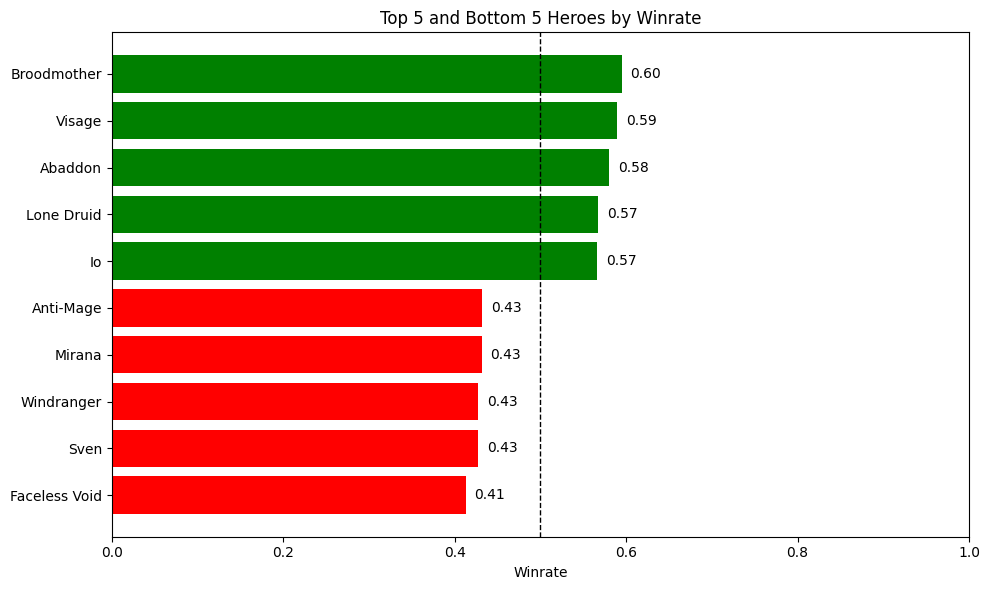

In [18]:
#top and bottom 5 hero winrates
import numpy as np
from collections import defaultdict

# Simulated variable: your list of matches
# Each match is a dict with 'team1', 'team2', 'team1_win'
# Example:
# prediction_data = [{'team1_win': False, 'team1': {...}, 'team2': {...}}, ...]

prediction_data = all_dota2_games

# Step 1: Track wins and total picks for each hero
hero_wins = defaultdict(int)
hero_total = defaultdict(int)

for match in prediction_data:
    team1_heroes = match['team1'].keys()
    team2_heroes = match['team2'].keys()
    
    if match['team1_win']:
        for hero in team1_heroes:
            hero_wins[hero] += 1
        for hero in team2_heroes:
            hero_wins[hero] += 0
    else:
        for hero in team1_heroes:
            hero_wins[hero] += 0
        for hero in team2_heroes:
            hero_wins[hero] += 1
    
    for hero in team1_heroes:
        hero_total[hero] += 1
    for hero in team2_heroes:
        hero_total[hero] += 1

# Step 2: Compute hero winrates
hero_winrates = {}
for hero in hero_total:
    hero_winrates[hero] = hero_wins[hero] / hero_total[hero]

# Step 3: Convert to array and compute stats
winrate_values = np.array(list(hero_winrates.values()))
mean_winrate = np.mean(winrate_values)
std_winrate = np.std(winrate_values)

# Optional: display
print(f"Average of all hero winrates: {mean_winrate:.4f}")
print(f"Standard deviation of hero winrates: {std_winrate:.4f}")

import matplotlib.pyplot as plt

# Sort heroes by winrate
sorted_heroes = sorted(hero_winrates.items(), key=lambda x: x[1])
worst_5 = sorted_heroes[:5]
best_5 = sorted_heroes[-5:]

# Combine and prepare for plotting
top_and_bottom = worst_5 + best_5
hero_names = [dota2_heroes[hero_id] for hero_id, _ in top_and_bottom] #CHANGE FOR DOTA2
winrates = [rate for _, rate in top_and_bottom]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(hero_names, winrates, color=['red']*5 + ['green']*5)
plt.axvline(0.5, color='black', linestyle='--', linewidth=1)
plt.xlabel("Winrate")
plt.title("Top 5 and Bottom 5 Heroes by Winrate")
plt.xlim(0, 1)

# Add winrate values next to bars
for bar, wr in zip(bars, winrates):
    plt.text(wr + 0.01 if wr < 0.9 else wr - 0.1, bar.get_y() + bar.get_height()/2,
             f"{wr:.2f}", va='center', ha='left' if wr < 0.9 else 'right', color='black')

plt.tight_layout()
plt.show()


## Step 1 - K-Means Clustering
clustering using the semantic positioning for one of the previous datasets

In [6]:
#define positional encodings
import numpy as np

def dota2_encode_hero_comp_as_matrix(team):
    matrix = np.zeros((len(dota2_hero_ids),5))
    for hero_id, position in team.items():
        matrix[dota2_hero_ids.index(hero_id)][position-1] = 1
    return matrix.flatten() #flatten the 5xN matrix to 1x(5*N)

def lol_encode_hero_comp_as_matrix(team):
    matrix = np.zeros((len(lol_hero_ids),5))
    for hero_id, position in team.items():
        matrix[lol_hero_ids.index(hero_id)][position-1] = 1
    return matrix.flatten() #flatten the 5xN matrix to 1x(5*N)

def positional_encode_dota2(dataset):
    encoded_drafts = []
    for game in dataset:
        for team in ('team1', 'team2'):
            encoded_drafts.append((dota2_encode_hero_comp_as_matrix(game[team]), game['team1_win'] if team == 'team1' else not game['team1_win']))
    return encoded_drafts

def positional_encode_lol(dataset):
    encoded_drafts = []
    for game in dataset:
        for team in ('team1', 'team2'):
            encoded_drafts.append((lol_encode_hero_comp_as_matrix(game[team]), game['team1_win'] if team == 'team1' else not game['team1_win']))
    return encoded_drafts

In [7]:
#define simple encodings
import numpy as np

def dota2_simple_encode_hero_comp_as_matrix(team):
    matrix = np.zeros(len(dota2_hero_ids))
    for hero_id, position in team.items():
        matrix[dota2_hero_ids.index(hero_id)] = 1
    return matrix.flatten() #flatten the 5xN matrix to 1x(5*N)

def lol_simple_encode_hero_comp_as_matrix(team):
    matrix = np.zeros(len(lol_hero_ids))
    for hero_id, position in team.items():
        matrix[lol_hero_ids.index(hero_id)] = 1
    return matrix.flatten() #flatten the 5xN matrix to 1x(5*N)

def simple_encode_dota2(dataset):
    encoded_drafts = []
    for game in dataset:
        for team in ('team1', 'team2'):
            encoded_drafts.append((dota2_simple_encode_hero_comp_as_matrix(game[team]), game['team1_win'] if team == 'team1' else not game['team1_win']))
    return encoded_drafts

def simple_encode_lol(dataset):
    encoded_drafts = []
    for game in dataset:
        for team in ('team1', 'team2'):
            encoded_drafts.append((lol_simple_encode_hero_comp_as_matrix(game[team]), game['team1_win'] if team == 'team1' else not game['team1_win']))
    return encoded_drafts

In [8]:
#define role encodings
import numpy as np

with open('official_roles.json', 'r') as file:
    role_data = json.load(file)

def get_roles(hero_id):
    return role_data[str(hero_id)]["roles"]

all_roles = list(get_roles(1).keys())

def dota2_role_encode_hero_comp_as_matrix(team):
    matrix = np.zeros((len(all_roles),5))
    for hero_id, position in team.items():
        roles = get_roles(hero_id)
        for role, value in roles.items():
            matrix[all_roles.index(role)][position-1] = value
    return matrix.flatten()

def role_encode_dota2(dataset):
    encoded_drafts = []
    for game in dataset:
        for team in ('team1', 'team2'):
            encoded_drafts.append((dota2_role_encode_hero_comp_as_matrix(game[team]), game['team1_win'] if team == 'team1' else not game['team1_win']))
    return encoded_drafts

In [9]:
#define simple role encodings Dota2
import numpy as np

with open('official_roles.json', 'r') as file:
    role_data = json.load(file)

def get_roles(hero_id):
    return role_data[str(hero_id)]["roles"]

all_roles = list(get_roles(1).keys())

def dota2_role_encode_hero_comp_as_matrix(team):
    matrix = np.zeros(len(all_roles))
    for hero_id, position in team.items():
        roles = get_roles(hero_id)
        for role, value in roles.items():
            matrix[all_roles.index(role)] += value
    return matrix.flatten()

def simple_role_encode_dota2(dataset):
    encoded_drafts = []
    for game in dataset:
        for team in ('team1', 'team2'):
            encoded_drafts.append((dota2_role_encode_hero_comp_as_matrix(game[team]), game['team1_win'] if team == 'team1' else not game['team1_win']))
    return encoded_drafts

In [77]:
#define simple role encodings LoL
import numpy as np

with open('lol_classes.json', 'r') as file:
    lol_role_data = json.load(file)

def lol_get_roles(hero_id):
    return lol_role_data[str(hero_id)]["roles"]

lol_all_roles = set()
for champ in lol_role_data.values():
    for role in champ['roles']:
        lol_all_roles.add(role)
lol_all_roles = list(lol_all_roles)

def lol_role_encode_hero_comp_as_matrix(team):
    matrix = np.zeros(len(lol_all_roles))
    for hero_id, position in team.items():
        roles = lol_get_roles(hero_id)
        for role in roles:
            matrix[lol_all_roles.index(role)] += 1
    return matrix.flatten()

def simple_role_encode_lol(dataset):
    encoded_drafts = []
    for game in dataset:
        for team in ('team1', 'team2'):
            encoded_drafts.append((lol_role_encode_hero_comp_as_matrix(game[team]), game['team1_win'] if team == 'team1' else not game['team1_win']))
    return encoded_drafts

In [78]:
## hero selection in 5 vectors, sorted by ingame position
#dataset = positional_encode_dota2(dota2_highelo_games)
#dataset = positional_encode_dota2(dota2_lowelo_games)
#dataset = positional_encode_lol(lol_highelo_games) #best n=9
#dataset = positional_encode_lol(lol_lowelo_games)

## hero roles, in multiple(5positions) or single vector - (length 9 roles)
#dataset = role_encode_dota2(dota2_highelo_games)
#dataset = role_encode_dota2(dota2_lowelo_games)
#dataset = simple_role_encode_dota2(dota2_highelo_games)
#dataset = simple_role_encode_dota2(dota2_lowelo_games)
dataset = simple_role_encode_lol(lol_highelo_games)
#dataset = simple_role_encode_lol(lol_lowelo_games)

## hero selection multiple hot in a single vector - BEST
#dataset = simple_encode_dota2(dota2_highelo_games)
#dataset = simple_encode_dota2(dota2_lowelo_games)
#dataset = simple_encode_lol(lol_highelo_games)
#dataset = simple_encode_lol(lol_lowelo_games)

wins = np.array([win for _, win in dataset])
X = np.array([draft for draft, _ in dataset])

In [68]:
print(lol_all_roles)
print(lol_highelo_games[0])
print(dataset[:2])

['Skirmisher', 'Warden', 'Marksman', 'Specialist', 'Battlemage', 'Mage', 'Diver', 'Catcher', 'Enchanter', 'Juggernaut', 'Vanguard', 'Artillery', 'Assassin', 'Burst']
{'team1_win': False, 'team1': {'24': 1, '72': 2, '81': 4, '910': 3, '111': 5}, 'team2': {'114': 1, '131': 2, '133': 3, '42': 4, '518': 5}}
[(array([0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 2.]), True), (array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), False)]


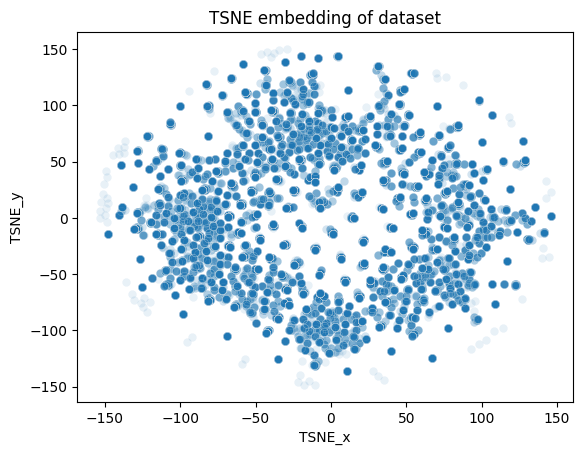

In [79]:
#TSNE embedding view
import matplotlib.pyplot as plt
import sklearn.manifold._t_sne
import seaborn as sns
import pandas as pd 

X_embedded = sklearn.manifold._t_sne.TSNE(n_components=2, random_state=1, perplexity=30).fit_transform(X)
X_embedded_df = pd.DataFrame(X_embedded, columns=['TSNE_x', 'TSNE_y'])

sns.scatterplot(x='TSNE_x', y='TSNE_y', data=X_embedded_df, alpha=0.1)
plt.title(f"TSNE embedding of dataset")
plt.show()

In [38]:
#define find_best_clustering()
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans
from sklearn import metrics

def find_best_clustering(X):
    N = 30
    scores = {}
    for n in range(2,N): #clusterin with 1 cluster useless
        print(f"Testing {n}")
        clustering = KMeans(n_clusters=n, n_init=5, random_state=42).fit(X)
        score = metrics.silhouette_score(X, clustering.labels_, metric='euclidean')
        scores[n] = (score, clustering.inertia_)
    return scores

Testing 2
Testing 3
Testing 4
Testing 5
Testing 6
Testing 7
Testing 8
Testing 9
Testing 10
Testing 11
Testing 12
Testing 13
Testing 14
Testing 15
Testing 16
Testing 17
Testing 18
Testing 19
Testing 20
Testing 21
Testing 22
Testing 23
Testing 24
Testing 25
Testing 26
Testing 27
Testing 28
Testing 29


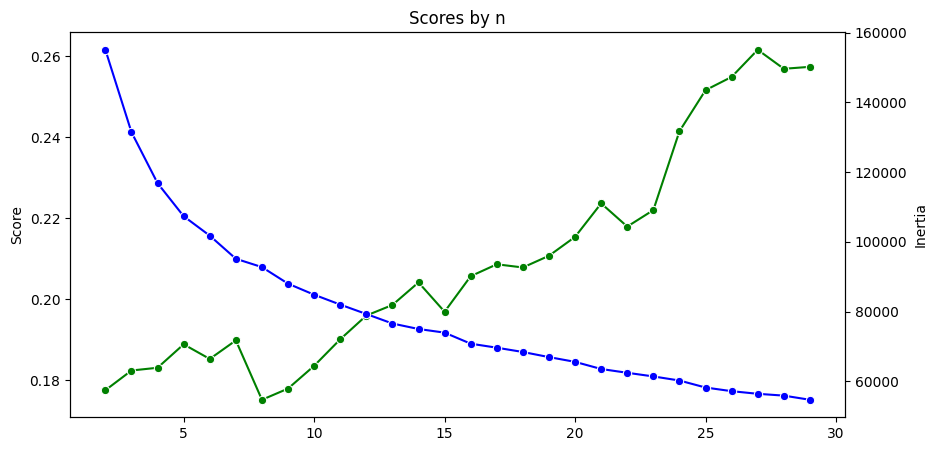

In [80]:
# Create plot of find_best_clustering()
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

scores = find_best_clustering(X)

scores_df = pd.DataFrame.from_dict(scores, orient="index", columns = ["Score", "Inertia"])
plt.figure(figsize=(10, 5))
sns.lineplot(data=scores_df.Score, marker="o", color="g")  # Line with points
ax2 = plt.twinx()
sns.lineplot(data=scores_df.Inertia, marker="o", color="b", ax=ax2)
#plt.xticks(scores_df.index)

# Labels and title
plt.xlabel("n")
#plt.ylabel("Score")
plt.title("Scores by n")

# Show plot
plt.show()

In [81]:
#create specific clustering
from sklearn.cluster import KMeans
from sklearn import metrics

clustering = KMeans(n_clusters=14, n_init=7, random_state=42).fit(X)
score = metrics.silhouette_score(X, clustering.labels_, metric='euclidean')
print('Inertia: ',clustering.inertia_)

Inertia:  75024.74324897


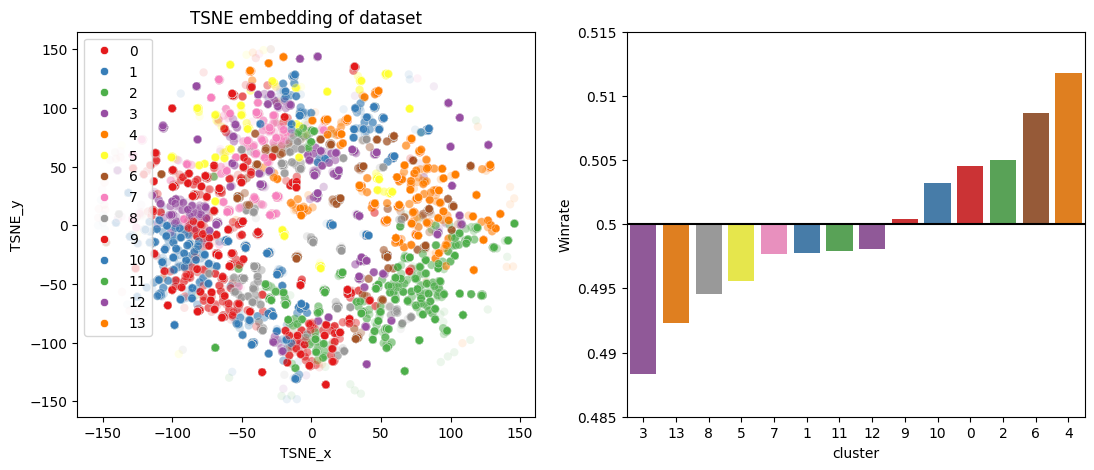

Cluster 0: 5183 datapoints
Cluster 1: 5732 datapoints
Cluster 2: 3200 datapoints
Cluster 3: 3606 datapoints
Cluster 4: 5342 datapoints
Cluster 5: 5499 datapoints
Cluster 6: 3798 datapoints
Cluster 7: 3018 datapoints
Cluster 8: 3759 datapoints
Cluster 9: 4616 datapoints
Cluster 10: 3392 datapoints
Cluster 11: 4306 datapoints
Cluster 12: 5748 datapoints
Cluster 13: 2805 datapoints


In [82]:
#TSNE embedding
import matplotlib.pyplot as plt
import sklearn.manifold._t_sne
import seaborn as sns
import pandas as pd 

#X_embedded = sklearn.manifold._t_sne.TSNE(n_components=2, random_state=1, perplexity=50).fit_transform(X)
#X_embedded_df = pd.DataFrame(X_embedded, columns=['TSNE_x', 'TSNE_y'])
X_embedded_df['wins'] = wins
X_embedded_df['cluster'] = clustering.labels_

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

sns.scatterplot(x='TSNE_x', y='TSNE_y', data=X_embedded_df, hue='cluster', palette='Set1', alpha=0.1, ax=ax[0])
ax[0].set_title(f"TSNE embedding of dataset")
leg = ax[0].legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)

cluster_winrates = X_embedded_df.groupby('cluster')["wins"].mean().to_frame()
adj_cluster_winrates = cluster_winrates - 0.5
adj_cluster_winrates = adj_cluster_winrates.reset_index()

sns.barplot(data=adj_cluster_winrates.sort_values('wins'), x='cluster', y='wins', hue='cluster', palette='Set1', legend=False, ax=ax[1], order=adj_cluster_winrates.sort_values('wins')['cluster'])
ax[1].set_ylabel('Winrate')
ax[1].axhline(y = 0, color = 'black', linestyle = '-')
# Get current y-ticks
current_ticks = ax[1].get_yticks()

# Modify the y-ticks to add 0.5
ax[1].set_yticks(current_ticks) 
ax[1].set_yticklabels([str(tick + 0.5)[:6] for tick in current_ticks])
ax[1].ylim = (-1, 1)
plt.show()

cluster_counts = X_embedded_df['cluster'].value_counts().sort_index()

# Print the count for each cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} datapoints")

In [83]:
#visualize hero distribution per cluster (LoL)
import numpy as np
import pandas as pd

labels = clustering.labels_

# Number of clusters
num_clusters = len(set(labels))
num_heroes = X.shape[1]

# Initialize frequency matrix
freq_matrix = np.zeros((num_heroes, num_clusters), dtype=int)

# Count pick frequency of each hero in each cluster
for i in range(len(X)):
    draft = X[i]
    cluster = labels[i]
    for hero_index in np.where(draft == 1)[0]:
        freq_matrix[hero_index, cluster] += 1

# Convert hero indices to names
#hero_names = [dota2_heroes[dota2_hero_ids[i]] for i in range(num_heroes)]
hero_names = lol_all_roles
assert len(hero_names) == num_heroes

# Create a DataFrame for plotting
df_freq = pd.DataFrame(freq_matrix, index=lol_all_roles,
                       columns=[f"Cluster {i}" for i in range(num_clusters)])

# Optional: Normalize (e.g., relative frequency within cluster)
df_norm = df_freq.div(df_freq.sum(axis=0), axis=1)

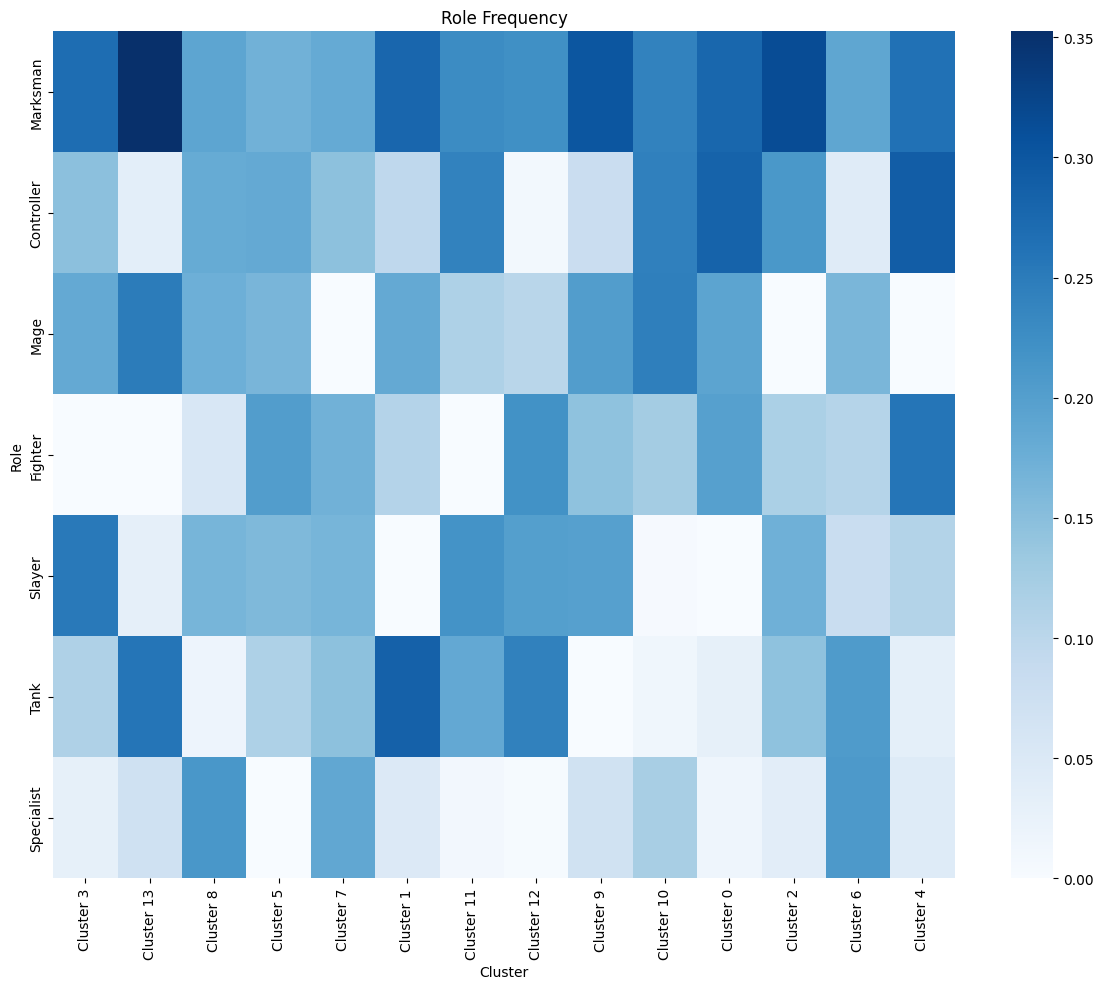

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: filter to top N champions
top_n = 30
top_champs = df_freq.sum(axis=1).sort_values(ascending=False).head(top_n).index
df_top = df_norm.loc[top_champs]

#order by winrate
cluster_order = adj_cluster_winrates.reset_index().sort_values('wins')['cluster'].tolist()
ordered_cols = [f"Cluster {i}" for i in cluster_order]

df_top_ordered = df_top[ordered_cols]

plt.figure(figsize=(12, 10))
sns.heatmap(df_top_ordered, cmap="Blues", annot=False)
plt.title("Role Frequency")
plt.xlabel("Cluster")
plt.ylabel("Role")
plt.tight_layout()
plt.show()

In [76]:
for id, stats in lol_role_data.items():
    if 'Battlemage' in stats['roles']:
        #print(stats['name'])
        pass
    if 'Vi' == stats['name']:
        print(stats['roles'])

['Battlemage']


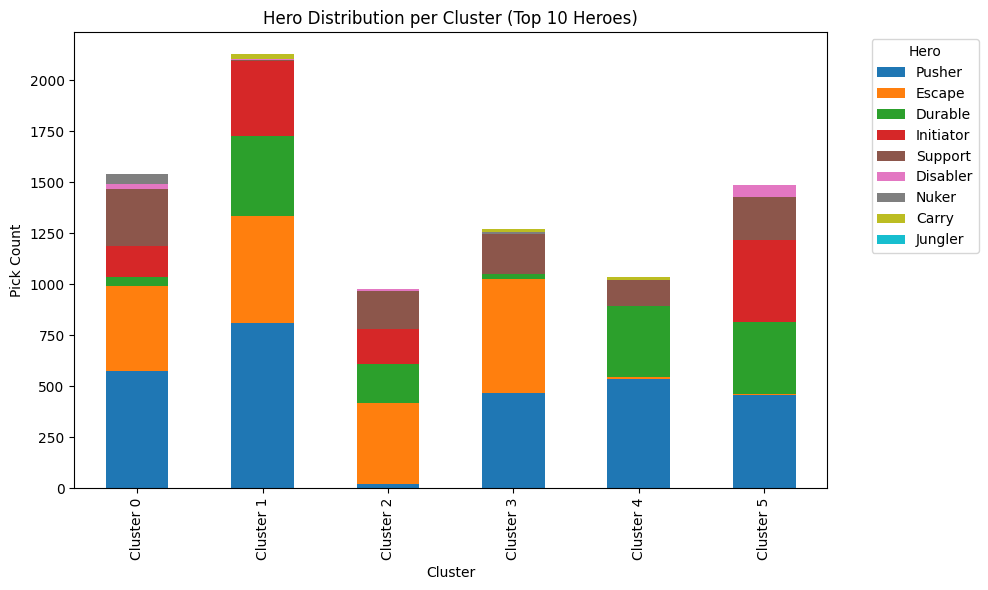

In [49]:
# Step 1: Filter to top 10 champions
top_10 = df_freq.sum(axis=1).sort_values(ascending=False).head(10).index
df_top10_bar = df_freq.loc[top_10].T  # Transpose for plotting (clusters as rows)

# Step 2: Plot
df_top10_bar.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab10")

plt.title("Hero Distribution per Cluster (Top 10 Heroes)")
plt.xlabel("Cluster")
plt.ylabel("Pick Count")
plt.legend(title="Hero", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

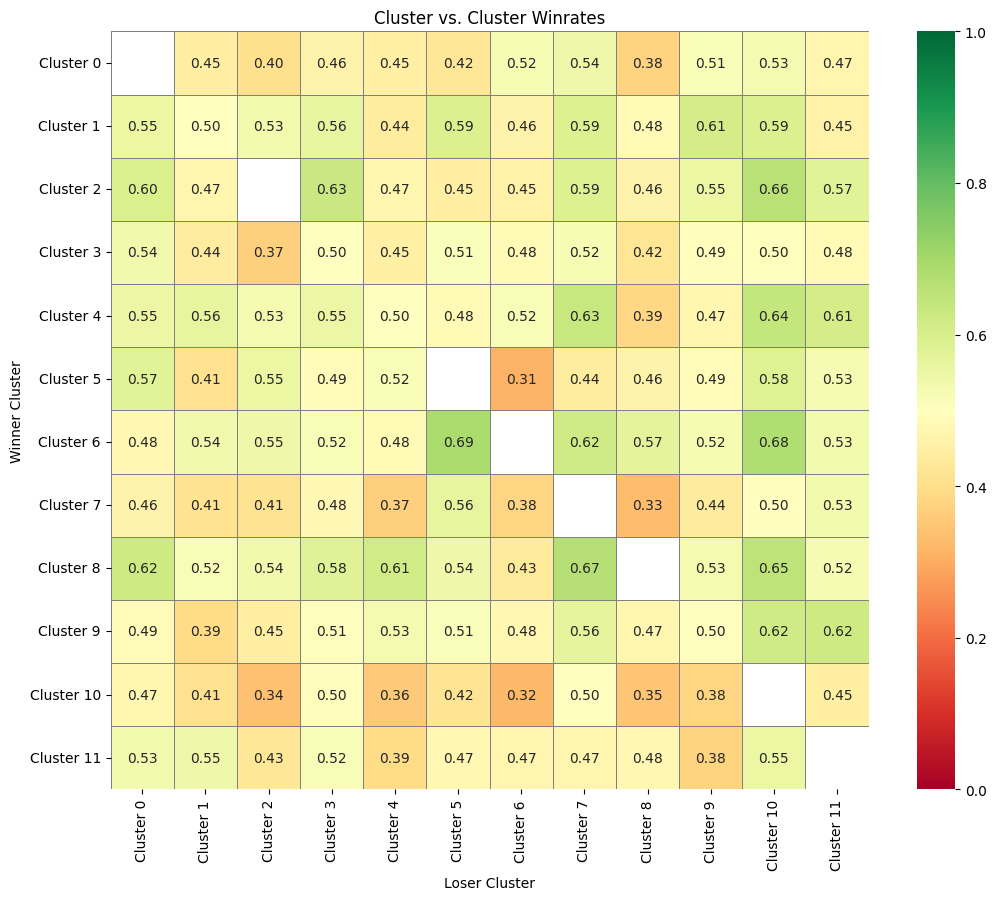

In [156]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Inputs ---
# X: your multi-hot encoded drafts (n_samples x n_heroes)
# labels: cluster labels for each draft
# wins: boolean array indicating if each draft won (True) or lost (False)
# Assumption: every pair of drafts represents a single match
num_clusters = len(set(labels))

# --- Step 1: Initialize matrices ---
win_matrix = np.zeros((num_clusters, num_clusters), dtype=int)
total_matrix = np.zeros((num_clusters, num_clusters), dtype=int)

# --- Step 2: Fill win/loss counts ---
for i in range(0, len(wins), 2):
    c1 = labels[i]
    c2 = labels[i + 1]
    win1 = wins[i]

    if win1:
        win_matrix[c1, c2] += 1
    else:
        win_matrix[c2, c1] += 1

    total_matrix[c1, c2] += 1
    total_matrix[c2, c1] += 1

# --- Step 3: Compute winrate matrix ---
with np.errstate(divide='ignore', invalid='ignore'):
    winrate_matrix = np.true_divide(win_matrix, total_matrix)
    winrate_matrix[total_matrix == 0] = np.nan

# --- Step 4: Compute weighted average winrates ---
# Row avg: how often a cluster wins
row_total = np.nansum(total_matrix, axis=1)
row_win = np.nansum(win_matrix, axis=1)
row_avg = 1 - np.divide(row_win, row_total, out=np.full_like(row_win, np.nan, dtype=float), where=row_total != 0)

# Col avg: how often a cluster loses (1 - others' winrate against it)
col_total = np.nansum(total_matrix, axis=0)
col_win = np.nansum(win_matrix, axis=0)
col_avg = np.divide(col_win, col_total, out=np.full_like(col_win, np.nan, dtype=float), where=col_total != 0)

# --- Step 5: Extend winrate matrix ---
# Add row_avg as an extra row
#winrate_matrix_ext = np.vstack([winrate_matrix, row_avg[np.newaxis, :]])

# Add col_avg + NaN as extra column
col_with_nan = np.append(col_avg, np.nan)[:, np.newaxis]
#winrate_matrix_ext = np.hstack([winrate_matrix_ext, col_with_nan])

# --- Step 6: Create labeled DataFrame ---
labels_plus = [f"Cluster {i}" for i in range(num_clusters)]# + ["Avg Winrate"]
winrate_df = pd.DataFrame(winrate_matrix, index=labels_plus, columns=labels_plus)

# --- Step 7: Plot ---
plt.figure(figsize=(11, 9))
sns.heatmap(winrate_df, annot=True, fmt=".2f", cmap="RdYlGn", vmin=0, vmax=1,
            linewidths=0.5, linecolor='gray', square=True)

plt.title("Cluster vs. Cluster Winrates")
plt.xlabel("Loser Cluster")
plt.ylabel("Winner Cluster")
plt.tight_layout()
plt.show()

## Step 2 - Log Regression
we test logistic regression with multiple feature sets, for the dataset chosen in the previous step

In [13]:
#train test split and dataset selection
import numpy as np
from sklearn.model_selection import train_test_split

#prediction_data = dota2_highelo_games
#prediction_data = dota2_lowelo_games
#prediction_data = lol_highelo_games
#prediction_data = lol_lowelo_games
prediction_data = dota2_highelo_games + dota2_lowelo_games

y = np.array([bool(match['team1_win']) for match in prediction_data])
X = [{'team1':list(match['team1'].keys()), 'team2':list(match['team2'].keys())} for match in prediction_data]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
#basic model
def dota2_encode_match(match):
    matrix = np.zeros(len(dota2_hero_ids) * 2)
    for hero_id in match['team1']:
        matrix[dota2_hero_ids.index(hero_id)] = 1
    for hero_id in match['team2']:
        matrix[len(dota2_hero_ids) + dota2_hero_ids.index(hero_id)] = 1
    return matrix

def dota2_encode_matches(matches):
    return np.array([dota2_encode_match(match) for match in matches])

def lol_encode_match(match):
    matrix = np.zeros(len(lol_hero_ids) * 2)
    for hero_id in match['team1']:
        matrix[lol_hero_ids.index(hero_id)] = 1
    for hero_id in match['team2']:
        matrix[len(lol_hero_ids) + lol_hero_ids.index(hero_id)] = 1
    return matrix

def lol_encode_matches(matches):
    return np.array([lol_encode_match(match) for match in matches])

X_train, X_test = dota2_encode_matches(X_train), dota2_encode_matches(X_test)
n_features = len(dota2_hero_ids) * 2
#X_train, X_test = lol_encode_matches(X_train), lol_encode_matches(X_test)
#n_features = len(lol_hero_ids) * 2

In [14]:
#counter/synergy model dota2
import numpy as np
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt

def dota2_calc_pair_winrate_matrix_same_team(games, wins):
    pair_wincount_matrix = np.zeros((len(dota2_hero_ids), len(dota2_hero_ids)))
    pair_matchcount_matrix = np.zeros((len(dota2_hero_ids), len(dota2_hero_ids)))
    
    hero_index = lambda x : dota2_hero_ids.index(x)
    
    for win, game in zip(wins, games):
        for team, won in [("team1", win), ("team2", not win)]:
            heroes = game[team]
            for a, b in combinations(heroes, 2):
                a, b = hero_index(a), hero_index(b)
                pair_matchcount_matrix[a][b] += 1
                pair_matchcount_matrix[b][a] += 1
                if won:
                    pair_wincount_matrix[a][b] += 1
                    pair_wincount_matrix[b][a] += 1

    with np.errstate(divide='ignore', invalid='ignore'):  # Avoid division by zero
        pair_winrate_matrix = np.nan_to_num(pair_wincount_matrix / pair_matchcount_matrix)
    for i in range(len(dota2_hero_ids)):
        for j in range(len(dota2_hero_ids)):
            if pair_matchcount_matrix[i][j] == 0:
                pair_winrate_matrix[i][j] = 0.5
    return pair_winrate_matrix

def dota2_calc_pair_winrate_matrix_opposite_team(games, wins):
    pair_wincount_matrix = np.zeros((len(dota2_hero_ids), len(dota2_hero_ids)))
    pair_matchcount_matrix = np.zeros((len(dota2_hero_ids), len(dota2_hero_ids)))

    hero_index = lambda x : dota2_hero_ids.index(x)
    
    for win, game in zip(wins, games):
        if win:
            winning_team, losing_team = 'team1', 'team2'
        else:
            winning_team, losing_team = 'team2', 'team1'
        for hero_a in game[winning_team]:
            for hero_b in game[losing_team]:
                a, b = hero_index(hero_a), hero_index(hero_b)
                pair_matchcount_matrix[a][b] += 1
                pair_matchcount_matrix[b][a] += 1
                pair_wincount_matrix[a][b] += 1

    with np.errstate(divide='ignore', invalid='ignore'):  # Avoid division by zero
        pair_winrate_matrix = np.nan_to_num(pair_wincount_matrix / pair_matchcount_matrix)
    for i in range(len(dota2_hero_ids)):
        for j in range(len(dota2_hero_ids)):
            if pair_matchcount_matrix[i][j] == 0:
                pair_winrate_matrix[i][j] = 0.5
    return pair_winrate_matrix

def dota2_cs_encode_match_as_matrix(match, synergy_matrix, counter_matrix):
    hero_index = lambda x : dota2_hero_ids.index(x)
    matrix = np.zeros(len(dota2_hero_ids) * 2 + 2)

    team1_heroes = [hero_index(hero) for hero in match['team1']]
    team2_heroes = [hero_index(hero) for hero in match['team2']]
    
    for hero_idx in team1_heroes:
        matrix[hero_idx] = 1
    for hero_idx in team2_heroes:
        matrix[len(dota2_hero_ids) + hero_idx] = 1
    
    team1_synergy = sum([synergy_matrix[a][b] for a,b in combinations(team1_heroes, 2)])
    team2_synergy = sum([synergy_matrix[a][b] for a,b in combinations(team2_heroes, 2)])
    #synergy difference
    matrix[-2] = team1_synergy - team2_synergy
    #counter score
    matrix[-1] = sum([counter_matrix[a][b] for a in team1_heroes for b in team2_heroes])
    return matrix

def dota2_cs_encode_matches(matches, wins, test_matches, test_wins):
    s_m = dota2_calc_pair_winrate_matrix_same_team(matches, wins)
    c_m = dota2_calc_pair_winrate_matrix_opposite_team(matches, wins)
    #s_m = dota2_calc_pair_winrate_matrix_same_team(np.concatenate((matches, test_matches)), np.concatenate((wins, test_wins)))
    #c_m = dota2_calc_pair_winrate_matrix_opposite_team(np.concatenate((matches, test_matches)), np.concatenate((wins, test_wins)))
    return np.array([dota2_cs_encode_match_as_matrix(match, s_m, c_m) for match in matches]), np.array([dota2_cs_encode_match_as_matrix(match, s_m, c_m) for match in test_matches])

X_train, X_test = dota2_cs_encode_matches(X_train, y_train, X_test, y_test)
n_features = (len(dota2_hero_ids) * 2) + 2

In [33]:
#counter/synergy model lol
import numpy as np
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt

def lol_calc_pair_winrate_matrix_same_team(games, wins):
    pair_wincount_matrix = np.zeros((len(lol_hero_ids), len(lol_hero_ids)))
    pair_matchcount_matrix = np.zeros((len(lol_hero_ids), len(lol_hero_ids)))
    
    hero_index = lambda x : lol_hero_ids.index(x)
    
    for win, game in zip(wins, games):
        for team, won in [("team1", win), ("team2", not win)]:
            heroes = game[team]
            for a, b in combinations(heroes, 2):
                a, b = hero_index(a), hero_index(b)
                pair_matchcount_matrix[a][b] += 1
                pair_matchcount_matrix[b][a] += 1
                if won:
                    pair_wincount_matrix[a][b] += 1
                    pair_wincount_matrix[b][a] += 1

    with np.errstate(divide='ignore', invalid='ignore'):  # Avoid division by zero
        pair_winrate_matrix = np.nan_to_num(pair_wincount_matrix / pair_matchcount_matrix)
    for i in range(len(lol_hero_ids)):
        for j in range(len(lol_hero_ids)):
            if pair_matchcount_matrix[i][j] == 0:
                pair_winrate_matrix[i][j] = 0.5
    return pair_winrate_matrix

def lol_calc_pair_winrate_matrix_opposite_team(games, wins):
    pair_wincount_matrix = np.zeros((len(lol_hero_ids), len(lol_hero_ids)))
    pair_matchcount_matrix = np.zeros((len(lol_hero_ids), len(lol_hero_ids)))

    hero_index = lambda x : lol_hero_ids.index(x)
    
    for win, game in zip(wins, games):
        if win:
            winning_team, losing_team = 'team1', 'team2'
        else:
            winning_team, losing_team = 'team2', 'team1'
        for hero_a in game[winning_team]:
            for hero_b in game[losing_team]:
                a, b = hero_index(hero_a), hero_index(hero_b)
                pair_matchcount_matrix[a][b] += 1
                pair_matchcount_matrix[b][a] += 1
                pair_wincount_matrix[a][b] += 1

    with np.errstate(divide='ignore', invalid='ignore'):  # Avoid division by zero
        pair_winrate_matrix = np.nan_to_num(pair_wincount_matrix / pair_matchcount_matrix)
    for i in range(len(lol_hero_ids)):
        for j in range(len(lol_hero_ids)):
            if pair_matchcount_matrix[i][j] == 0:
                pair_winrate_matrix[i][j] = 0.5
    return pair_winrate_matrix

def lol_cs_encode_match_as_matrix(match, synergy_matrix, counter_matrix):
    hero_index = lambda x : lol_hero_ids.index(x)
    matrix = np.zeros(len(lol_hero_ids) * 2 + 2)

    team1_heroes = [hero_index(hero) for hero in match['team1']]
    team2_heroes = [hero_index(hero) for hero in match['team2']]
    
    for hero_idx in team1_heroes:
        matrix[hero_idx] = 1
    for hero_idx in team2_heroes:
        matrix[len(lol_hero_ids) + hero_idx] = 1
    
    team1_synergy = sum([synergy_matrix[a][b] for a,b in combinations(team1_heroes, 2)])
    team2_synergy = sum([synergy_matrix[a][b] for a,b in combinations(team2_heroes, 2)])
    #synergy difference
    matrix[-2] = team1_synergy - team2_synergy
    #counter score
    matrix[-1] = sum([counter_matrix[a][b] for a in team1_heroes for b in team2_heroes])
    return matrix

def lol_cs_encode_matches(matches, wins, test_matches, test_wins):
    s_m = lol_calc_pair_winrate_matrix_same_team(matches, wins)
    c_m = lol_calc_pair_winrate_matrix_opposite_team(matches, wins)
    #s_m = lol_calc_pair_winrate_matrix_same_team(np.concatenate((matches, test_matches)), np.concatenate((wins, test_wins)))
    #c_m = lol_calc_pair_winrate_matrix_opposite_team(np.concatenate((matches, test_matches)), np.concatenate((wins, test_wins)))
    return np.array([lol_cs_encode_match_as_matrix(match, s_m, c_m) for match in matches]), np.array([lol_cs_encode_match_as_matrix(match, s_m, c_m) for match in test_matches])

X_train, X_test = lol_cs_encode_matches(X_train, y_train, X_test, y_test)
n_features = (len(lol_hero_ids) * 2) + 2

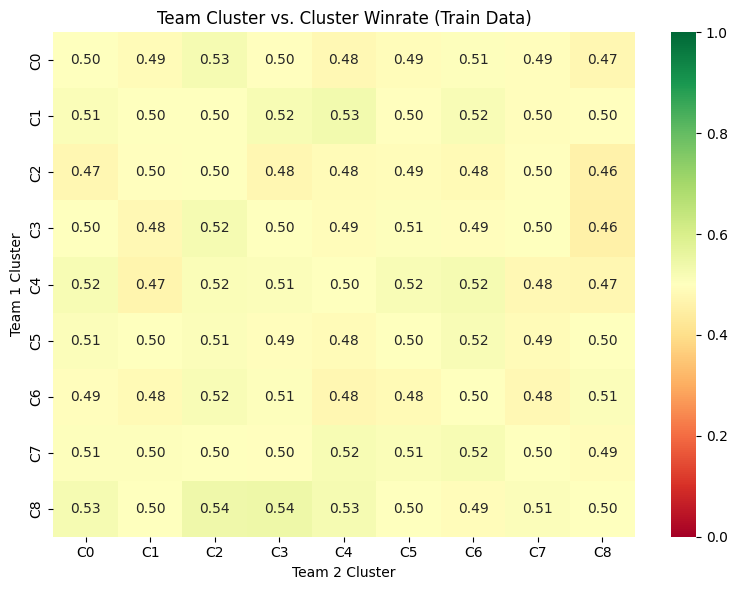

In [213]:
#add compute cluster winrates to basic LoL
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Prepare y and raw draft info
y = np.array([bool(match['team1_win']) for match in prediction_data])
X_raw = [{'team1': list(match['team1'].keys()), 'team2': list(match['team2'].keys())} for match in prediction_data]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.25, random_state=42)

# Multi-hot encoding
def draft_to_vector(team):
    vec = np.zeros(len(lol_hero_ids), dtype=int)
    for hero_id in team:
        idx = lol_hero_ids.index(hero_id)
        vec[idx] = 1
    return vec

# Step 1: Cluster individual team drafts in training set
all_train_teams = []
for match in X_train_raw:
    all_train_teams.append(draft_to_vector(match['team1']))
    all_train_teams.append(draft_to_vector(match['team2']))

team_vectors = np.array(all_train_teams)

# Step 2: Cluster team drafts
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
team_cluster_labels = kmeans.fit_predict(team_vectors)

# Step 3: Build cluster mapping (index 0 = match 0 team1, index 1 = match 0 team2, etc.)
team_cluster_lookup = team_cluster_labels.reshape(-1)

# Step 4: Build inter-cluster winrate matrix
win_matrix = np.zeros((n_clusters, n_clusters), dtype=int)
total_matrix = np.zeros((n_clusters, n_clusters), dtype=int)

for i, match in enumerate(X_train_raw):
    c1 = team_cluster_lookup[i * 2]      # team1 cluster
    c2 = team_cluster_lookup[i * 2 + 1]  # team2 cluster

    if y_train[i]:
        win_matrix[c1, c2] += 1
    else:
        win_matrix[c2, c1] += 1

    total_matrix[c1, c2] += 1
    total_matrix[c2, c1] += 1

with np.errstate(divide='ignore', invalid='ignore'):
    cluster_winrates = np.true_divide(win_matrix, total_matrix)
    cluster_winrates[total_matrix == 0] = 0.5  # default if unseen

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_wr = pd.DataFrame(cluster_winrates,
                     index=[f"C{i}" for i in range(n_clusters)],
                     columns=[f"C{i}" for i in range(n_clusters)])

plt.figure(figsize=(8, 6))
sns.heatmap(df_wr, annot=True, fmt=".2f", cmap="RdYlGn", vmin=0, vmax=1)
plt.title("Team Cluster vs. Cluster Winrate (Train Data)")
plt.xlabel("Team 2 Cluster")
plt.ylabel("Team 1 Cluster")
plt.tight_layout()
plt.show()

In [214]:
def encode_match(match, model, winrate_matrix):
    t1_vec = draft_to_vector(match['team1'])
    t2_vec = draft_to_vector(match['team2'])
    c1 = model.predict([t1_vec])[0]
    c2 = model.predict([t2_vec])[0]

    winrate = winrate_matrix[c1, c2] if not np.isnan(winrate_matrix[c1, c2]) else 0.5

    # Combined feature vector: team1, team2, cluster winrate
    return np.concatenate([t1_vec, t2_vec, [winrate]])

X_train = np.array([encode_match(match, kmeans, cluster_winrates) for match in X_train_raw])
X_test = np.array([encode_match(match, kmeans, cluster_winrates) for match in X_test_raw])
n_features = len(lol_hero_ids) * 2 + 1

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

model = keras.Sequential([
    layers.Input((n_features,)),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()
# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - accuracy: 0.5736 - loss: 0.7030 - val_accuracy: 0.5788 - val_loss: 0.6773
Epoch 2/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.6665 - loss: 0.6183 - val_accuracy: 0.5792 - val_loss: 0.6839
Epoch 3/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.6868 - loss: 0.5938 - val_accuracy: 0.5775 - val_loss: 0.6945
Epoch 4/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.7062 - loss: 0.5730 - val_accuracy: 0.5763 - val_loss: 0.7040
Epoch 5/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.7106 - loss: 0.5644 - val_accuracy: 0.5743 - val_loss: 0.7118
Epoch 6/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.7167 - loss: 0.5546 - val_accuracy: 0.5730 - val_loss: 0.7193
Epoch 7/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.7204 - loss: 0.5468 - val_accuracy: 0.5711 - val_loss: 0.7251
Epoch 8/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.7279 - loss: 0.5390 - 

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


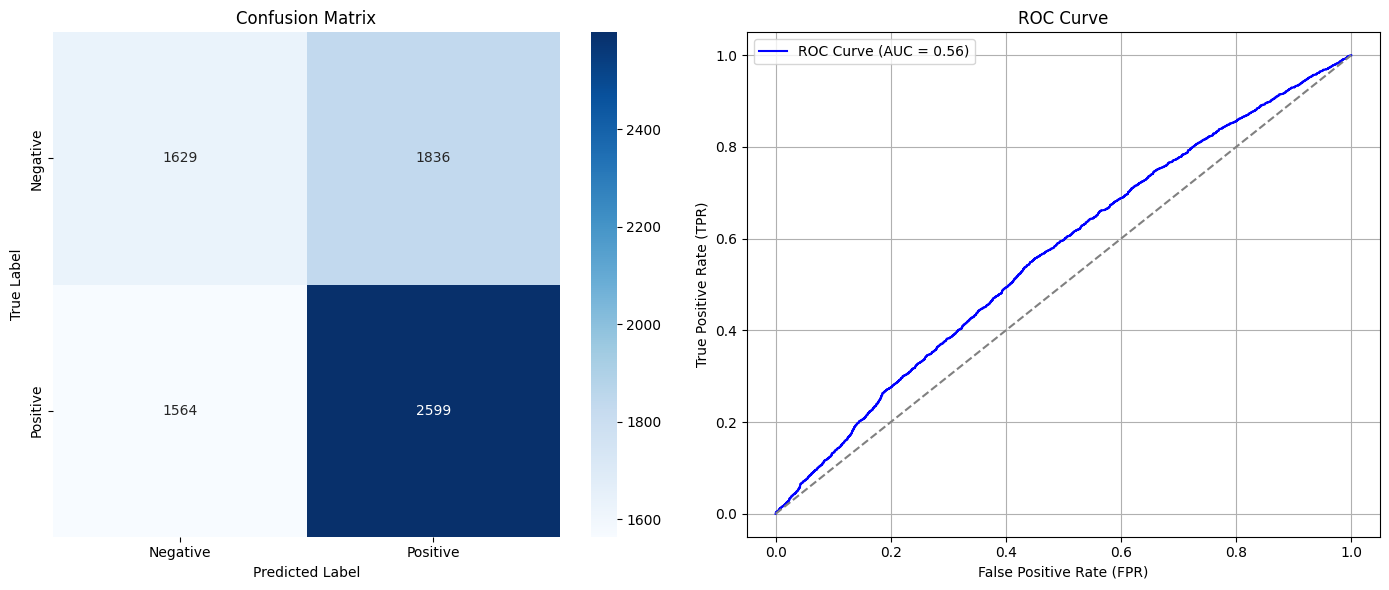

Accuracy: 0.5543
ROC AUC Score: 0.5646


In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score

# Get predictions and probabilities
y_probs = model.predict(X_test)  # Probabilities for class 1
y_pred = (y_probs > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

# Create figure with subplots
plt.figure(figsize=(14, 6))

# Confusion matrix subplot
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negative", "Positive"], 
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")

# ROC curve subplot
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")